In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import zipfile
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow import keras
import zipfile
import os
import shutil
from shutil import copyfile
import random
from tensorflow.keras import Model
import csv
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

### Building & Training Neural Networks

In [ ]:
# simpliest example ever
xs = np.array([-1.0, 0.0, 1.0, 2.0, 3.0, 4.0], dtype=float)
ys = np.array([-4.0, 1.0, 6.0, 11.0, 16.0, 21.0], dtype=float)

model = tf.keras.Sequential([tf.keras.layers.Dense(units=1, input_shape=[1])])
model.compile(optimizer='sgd', loss='mean_squared_error')
history = model.fit(xs, ys, epochs=1000)

In [ ]:
# call dataset
mnist = tf.keras.datasets.mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()


def reshape_and_normalize(images):
  images = np.expand_dims(images,axis=-1)
  images = images / 255
  return images

# ensure inputs to a model are the correct shape
training_images_ = reshape_and_normalize(training_images)

# ensure you can match test data to the input shape of a neural network
# ensure you can match output of data of a neural network to specified input shape for test data
test_images_ = reshape_and_normalize(test_images)

print(training_images_.shape,test_images_.shape)

# use callbacks to trigger end of training cycles
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if logs.get('accuracy') is not None and logs.get('accuracy') > .995:
      print("\nReached 99.5% accuracy so cancelling training")
      self.model.stop_training = True

callbacks = myCallback()

# build and train models for multi-classification
# build sequential models with multiple layers
model = tf.keras.models.Sequential([
    keras.layers.Conv2D(filters=16,kernel_size=(3,3),activation='relu',input_shape=(28,28,1)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(10,activation='softmax')
])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(training_images_,training_labels,validation_data=(test_images_,test_labels),epochs=100,callbacks=[callbacks])
print(model.evaluate(test_images_,test_labels))

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1) (10000, 28, 28, 1)
Epoch 1/100
1875/1875 [==============================] - 11s 4ms/step - loss: 0.1631 - accuracy: 0.9526 - val_loss: 0.0621 - val_accuracy: 0.9791
Epoch 2/100
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0562 - accuracy: 0.9827 - val_loss: 0.0637 - val_accuracy: 0.9783
Epoch 3/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0373 - accuracy: 0.9881 - val_loss: 0.0504 - val_accuracy: 0.9845
Epoch 4/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0254 - accuracy: 0.9928 - val_loss: 0.0464 - val_accuracy: 0.9848
Epoch 5/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0178 - accuracy: 0.9944 - val_loss: 0.0453 - val_accuracy: 0.9858
Epoch 6/100
1864/1875 [============================>.] - ETA: 0s - loss: 0.0128 - accuracy: 0.9958
Reached 99.5% accuracy so cancelling training
313/313 [================

In [ ]:
# build and train models to process real-world images
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

--2024-03-09 00:30:36--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.141.207, 2607:f8b0:4023:c0b::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human.zip’

horse-or-human.zip  100%[===================>] 142.65M   213MB/s    in 0.7s    

2024-03-09 00:30:37 (213 MB/s) - ‘horse-or-human.zip’ saved [149574867/149574867]

--2024-03-09 00:30:37--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.141.207, 2607:f8b0:4023:c0b::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

In [ ]:
# Unzip training set
local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./horse-or-human')

# Unzip validation set
local_zip = './validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./validation-horse-or-human')

zip_ref.close()

In [ ]:
train_horse_dir = os.path.join('./horse-or-human/horses')
train_human_dir = os.path.join('./horse-or-human/humans')
validation_horse_dir = os.path.join('./validation-horse-or-human/horses')
validation_human_dir = os.path.join('./validation-horse-or-human/humans')

# Use Image Data Generatator
# Understand how ImageDataGenerator Labels images based on the directory structure
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    './horse-or-human/',
    target_size=(150,150),
    batch_size=128,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    './validation-horse-or-human/',
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


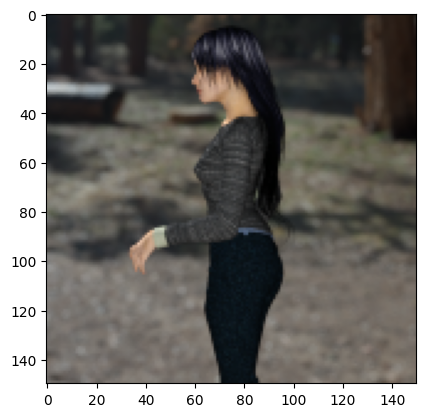

In [ ]:
plt.imshow(next(train_generator)[0][0]);

In [ ]:
# build and train models for binary classification
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    # binary classification has a dense layer of 1 and sigmoid activation function
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

history = model.fit(
      train_generator,
      steps_per_epoch=8,
      epochs=15,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/15
8/8 [==============================] - 11s 792ms/step - loss: 0.6962 - accuracy: 0.4950 - val_loss: 0.6951 - val_accuracy: 0.5000
Epoch 2/15
8/8 [==============================] - 6s 803ms/step - loss: 0.6863 - accuracy: 0.5206 - val_loss: 0.6958 - val_accuracy: 0.5000
Epoch 3/15
8/8 [==============================] - 6s 777ms/step - loss: 0.7644 - accuracy: 0.6841 - val_loss: 0.5079 - val_accuracy: 0.8320
Epoch 4/15
8/8 [==============================] - 8s 1s/step - loss: 0.4432 - accuracy: 0.8521 - val_loss: 0.5457 - val_accuracy: 0.8242
Epoch 5/15
8/8 [==============================] - 6s 782ms/step - loss: 0.4454 - accuracy: 0.8187 - val_loss: 0.6716 - val_accuracy: 0.7695
Epoch 6/15
8/8 [==============================] - 7s 819ms/step - loss: 0.2584 - accuracy: 0.9180 - val_loss: 0.8467 - val_accuracy: 0.8164
Epoch 7/15
8/8 [==============================] - 7s 860ms/step - loss: 0.2050 - accuracy: 0.9277 - val_loss: 0.8877 - val_accuracy: 0.8281
Epoch 8/15
8/8 [======

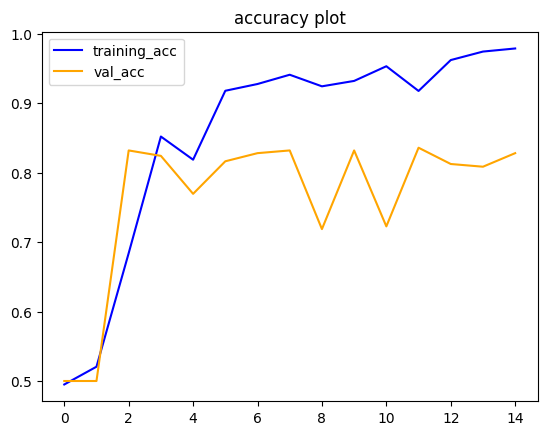

In [ ]:
# plot accuracy of trained model
plt.plot(list(range(0,15)),history.history['accuracy'],color="blue",label="training_acc")
plt.plot(list(range(0,15)),history.history['val_accuracy'],color="orange",label="val_acc")
plt.title("accuracy plot")
plt.legend();

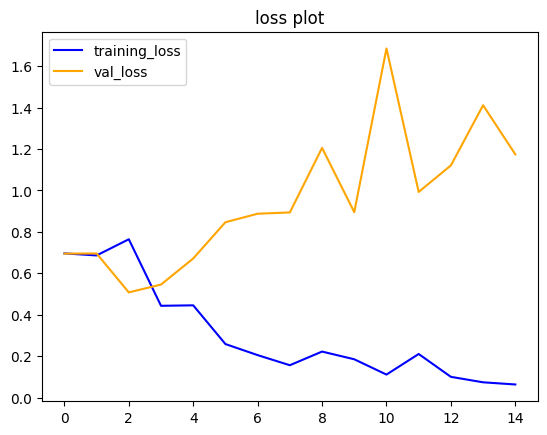

In [ ]:
# plot loss of trained model
plt.plot(list(range(0,15)),history.history['loss'],color="blue",label="training_loss")
plt.plot(list(range(0,15)),history.history['val_loss'],color="orange",label="val_loss")
plt.title("loss plot")
plt.legend();

In [ ]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/content/cats-and-dogs.zip"

local_zip = '/content/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

--2024-02-28 23:51:59--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 96.16.68.252, 2600:1406:bc00:a83::317f, 2600:1406:bc00:a8e::317f
Connecting to download.microsoft.com (download.microsoft.com)|96.16.68.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/content/cats-and-dogs.zip’

/content/cats-and-d 100%[===================>] 786.67M   145MB/s    in 9.0s    

2024-02-28 23:52:08 (87.1 MB/s) - ‘/content/cats-and-dogs.zip’ saved [824887076/824887076]



In [ ]:
# Define root directory
root_dir = '/content/cats-v-dogs'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

def create_train_test_dirs(root_path):

  os.makedirs(os.path.join(root_path, 'training'))
  os.makedirs(os.path.join(f'{root_path}/training', 'dogs'))
  os.makedirs(os.path.join(f'{root_path}/training', 'cats'))
  os.makedirs(os.path.join(root_path, 'testing'))
  os.makedirs(os.path.join(f'{root_path}/testing', 'dogs'))
  os.makedirs(os.path.join(f'{root_path}/testing', 'cats'))

try:
  create_train_test_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/content/cats-v-dogs/testing
/content/cats-v-dogs/training
/content/cats-v-dogs/testing/dogs
/content/cats-v-dogs/testing/cats
/content/cats-v-dogs/training/dogs
/content/cats-v-dogs/training/cats


In [ ]:
# understand how imagedatagenerator labels images based on the directory structure
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  shuffled_source = random.sample(os.listdir(SOURCE), len(os.listdir(SOURCE)))
  training_number = int(len(shuffled_source) * SPLIT_SIZE)

  i = 0
  target = TRAINING

  for item in shuffled_source:
    item_source = os.path.join(SOURCE, item)
    if os.path.getsize(item_source) == 0:
      print(f'{item} is zero length, so ignoring.')
    else:
      copyfile(item_source, os.path.join(target, item))
      i += 1
    if i == training_number:
      target = TESTING


CAT_SOURCE_DIR = "/content/PetImages/Cat/"
DOG_SOURCE_DIR = "/content/PetImages/Dog/"

TRAINING_DIR = "/content/cats-v-dogs/training/"
TESTING_DIR = "/content/cats-v-dogs/testing/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
TESTING_CATS_DIR = os.path.join(TESTING_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
TESTING_DOGS_DIR = os.path.join(TESTING_DIR, "dogs/")

if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_CATS_DIR)) > 0:
  for file in os.scandir(TESTING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_DOGS_DIR)) > 0:
  for file in os.scandir(TESTING_DOGS_DIR):
    os.remove(file.path)

split_size = .9

split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

print(f"\n\nThere are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(TESTING_CATS_DIR))} images of cats for testing")
print(f"There are {len(os.listdir(TESTING_DOGS_DIR))} images of dogs for testing")

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


There are 11250 images of cats for training
There are 11250 images of dogs for training
There are 1250 images of cats for testing
There are 1250 images of dogs for testing


In [ ]:
# use image augmentation to prevent overfitting
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=64,
                                                      class_mode='binary',
                                                      target_size=(150, 150))


validation_datagen = ImageDataGenerator(rescale = 1./255.)
validation_generator = validation_datagen.flow_from_directory(directory=TESTING_DIR,
                                                                batch_size=64,
                                                                class_mode='binary',
                                                                target_size=(150, 150))

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


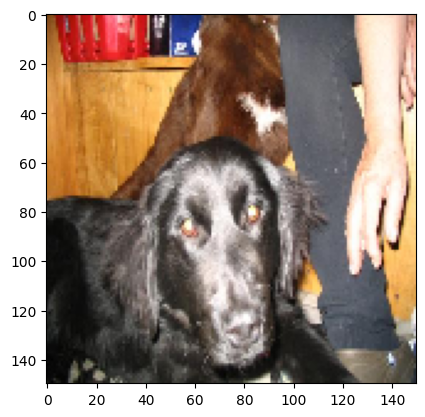

In [ ]:
plt.imshow(next(train_generator)[0][3])

In [ ]:
model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

### Building and training neural network models using Tensorflow 2.x

Transfer Learning Models

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
# downloading model
import pickle
from google.colab import files

with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

files.download('history.pkl')

In [ ]:
# use pretrained model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers

local_weights_file = '/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# if you want to load in weights, set weigths to None and uncomment load_weights
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')

#pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

In [ ]:
# extract features from pretrained model
# play around with it to see which layer extraction performs better
last_layer = pre_trained_model.get_layer('mixed7') #mixed7
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [ ]:
# create model with pretrained weights
from tensorflow.keras import Model

# data rescaling
train_datagen = ImageDataGenerator(rescale = 1./255)
train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=64,
                                                      class_mode='binary', # binary for binary, categorical for 3 or more classes
                                                      target_size=(150, 150))


validation_datagen = ImageDataGenerator(rescale = 1./255.)
validation_generator = validation_datagen.flow_from_directory(directory=TESTING_DIR,
                                                                batch_size=64,
                                                                class_mode='binary',
                                                                target_size=(150, 150))

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

# use pretrained model
model = Model(pre_trained_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.0001),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Epoch 1/20


100/100 - 20s - loss: 0.5402 - accuracy: 0.8314 - val_loss: 0.1825 - val_accuracy: 0.9252 - 20s/epoch - 202ms/step
Epoch 2/20
100/100 - 12s - loss: 0.2154 - accuracy: 0.9133 - 12s/epoch - 117ms/step
Epoch 3/20
100/100 - 12s - loss: 0.1644 - accuracy: 0.9366 - 12s/epoch - 119ms/step
Epoch 4/20
100/100 - 12s - loss: 0.1304 - accuracy: 0.9478 - 12s/epoch - 116ms/step
Epoch 5/20
100/100 - 11s - loss: 0.1283 - accuracy: 0.9474 - 11s/epoch - 113ms/step
Epoch 6/20
100/100 - 11s - loss: 0.1104 - accuracy: 0.9573 - 11s/epoch - 113ms/step
Epoch 7/20
100/100 - 11s - loss: 0.0891 - accuracy: 0.9669 - 11s/epoch - 115ms/step
Epoch 8/20
100/100 - 12s - loss: 0.0752 - accuracy: 0.9705 - 12s/epoch - 116ms/step
Epoch 9/20
100/100 - 11s - loss: 0.0772 - accuracy: 0.9708 - 11s/epoch - 109ms/step
Epoch 10/20
100/100 - 11s - loss: 0.0592 - accuracy: 0.9783 - 11s/epoch - 114ms/step
Epoch 11/20
100/100 - 11s - loss: 0.0463 - accuracy: 0.9833 - 11s/epoch - 113ms/step
Epoch 12/20
100/100 - 11s - loss: 0.0525 - 

### Natural Language Processing

In [ ]:
local_zip = '/content/BBC News Train.csv.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
with open("BBC News Train.csv","r") as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"Each data point looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

ArticleId,Text,Category

Each data point looks like this:

1833,worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002.

In [ ]:
# prepare text to use in TensorFlow models
# remove stopwords
def remove_stopwords(sentence):
    # List of stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

    # Sentence converted to lowercase-only
    sentence = sentence.lower()

    words = sentence.split()
    results_words = [word for word in words if word not in stopwords]
    sentence = ' '.join(results_words)
    return sentence

def parse_data_from_file(filename):
    sentences = []
    labels = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')

        # Skip header
        next(reader, None)

        for row in reader:
            labels.append(remove_stopwords(row[2]))
            sentences.append(remove_stopwords(row[1]))

    return sentences, labels

remove_stopwords("I am testing a silly sentence and I am tired I need ice cream")

'testing silly sentence tired need ice cream'

In [ ]:
sentences, labels = parse_data_from_file("BBC News Train.csv")

print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"First sentence has {len(sentences[0].split())} words (after removing stopwords).\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:5]}")

There are 1490 sentences in the dataset.

First sentence has 203 words (after removing stopwords).

There are 1490 labels in the dataset.

The first 5 labels are ['business', 'business', 'business', 'tech', 'business']


In [ ]:
# global variables
NUM_WORDS = 1000
EMBEDDING_DIM = 16
MAXLEN = 120
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

In [ ]:
def train_val_split(sentences, labels, training_split):
    train_size = int(len(sentences)*training_split)
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]
    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
    return train_sentences, validation_sentences, train_labels, validation_labels

train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)
print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 1192 sentences for training.

There are 1192 labels for training.

There are 298 sentences for validation.

There are 298 labels for validation.


In [ ]:
def fit_tokenizer(sentences, num_words, oov_token):
    tokenizer = Tokenizer(num_words=num_words,oov_token=oov_token)
    tokenizer.fit_on_texts(sentences)
    return tokenizer

def get_padded_sequences(tokenizer, sentences, padding, maxlen):
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences,maxlen=maxlen,padding=padding)
    return padded_sequences

def seq_and_pad(sentences, tokenizer, padding, maxlen):
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding)
    return padded_sequences

tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (1192, 120)

Padded validation sequences have shape: (298, 120)


In [ ]:
def tokenize_labels(all_labels, split_labels):
    label_tokenizer = Tokenizer()
    label_tokenizer.fit_on_texts(all_labels)
    label_seq = label_tokenizer.texts_to_sequences(split_labels)
    #label_seq_np = pd.DataFrame(label_seq).values - 1
    label_seq_np = np.array(label_seq) - 1
    return label_seq_np

train_label_seq = tokenize_labels(labels, train_labels)
val_label_seq = tokenize_labels(labels, val_labels)

print(f"First 5 labels of the training set should look like this:\n{train_label_seq[:5]}\n")
print(f"First 5 labels of the validation set should look like this:\n{val_label_seq[:5]}\n")
print(f"Tokenized labels of the training set have shape: {train_label_seq.shape}\n")
print(f"Tokenized labels of the validation set have shape: {val_label_seq.shape}\n")

First 5 labels of the training set should look like this:
[[1]
 [1]
 [1]
 [4]
 [1]]

First 5 labels of the validation set should look like this:
[[3]
 [3]
 [2]
 [1]
 [4]]

Tokenized labels of the training set have shape: (1192, 1)

Tokenized labels of the validation set have shape: (298, 1)



In [ ]:
# global variables
NUM_WORDS = 1000
EMBEDDING_DIM = 16
MAXLEN = 120
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

In [ ]:
# create a model to classify text for either binary or multi-class categorization
def create_model(num_words, embedding_dim, maxlen):

    tf.random.set_seed(123)


    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax') # use softmax for multi-class
    ])

    model.compile(loss='sparse_categorical_crossentropy', # you need to use this function if you multi-class labels are NOT one hot encoded
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)
history = model.fit(train_padded_seq, train_label_seq, epochs=30, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/30
38/38 [==============================] - 7s 146ms/step - loss: 1.6033 - accuracy: 0.3557 - val_loss: 1.5990 - val_accuracy: 0.2785
Epoch 2/30
38/38 [==============================] - 4s 98ms/step - loss: 1.5869 - accuracy: 0.2584 - val_loss: 1.5803 - val_accuracy: 0.3725
Epoch 3/30
38/38 [==============================] - 2s 51ms/step - loss: 1.5582 - accuracy: 0.5008 - val_loss: 1.5453 - val_accuracy: 0.5134
Epoch 4/30
38/38 [==============================] - 1s 36ms/step - loss: 1.5079 - accuracy: 0.5889 - val_loss: 1.4889 - val_accuracy: 0.6174
Epoch 5/30
38/38 [==============================] - 1s 35ms/step - loss: 1.4314 - accuracy: 0.6611 - val_loss: 1.4061 - val_accuracy: 0.6879
Epoch 6/30
38/38 [==============================] - 1s 19ms/step - loss: 1.3301 - accuracy: 0.6971 - val_loss: 1.3042 - val_accuracy: 0.7047
Epoch 7/30
38/38 [==============================] - 1s 18ms/step - loss: 1.2134 - accuracy: 0.7466 - val_loss: 1.1968 - val_accuracy: 0.7047
Epoch 8/30
3

In [ ]:
# example of LSTM
model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_DIM, MAXLEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_dim, return_sequences=True)), # return = TRUE if you your next layer is a lstm/gru/rnn
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')])

model_2.compile(loss='sparse_categorical_crossentropy', # you need to use this function if you multi-class labels are NOT one hot encoded
                  optimizer='adam',
                  metrics=['accuracy'])

history = model_2.fit(train_padded_seq, train_label_seq, epochs=30, validation_data=(val_padded_seq, val_label_seq))

In [ ]:
NUM_WORDS = 1000
EMBEDDING_DIM = 16
MAXLEN = 120
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

# CONVD Layer
model_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_DIM, MAXLEN),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

model_3.compile(loss='sparse_categorical_crossentropy', # you need to use this function if you multi-class labels are NOT one hot encoded
                  optimizer='adam',
                  metrics=['accuracy'])

history = model_3.fit(train_padded_seq, train_label_seq, epochs=30, validation_data=(val_padded_seq, val_label_seq))

In [ ]:
# example of GRU
model_4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_DIM, MAXLEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(lstm1_dim, return_sequences=True)), # return = TRUE if you your next layer is a lstm/gru/rnn
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(lstm2_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')])

model_4.compile(loss='sparse_categorical_crossentropy', # you need to use this function if you multi-class labels are NOT one hot encoded
                  optimizer='adam',
                  metrics=['accuracy'])

history = model_4.fit(train_padded_seq, train_label_seq, epochs=30, validation_data=(val_padded_seq, val_label_seq))

In [ ]:
# using pretrained weights- they require string input
train_data_tf, train_labels_tf = tf.constant(train_sentences, dtype=tf.string), tf.constant(train_label_seq , dtype=tf.int32)
test_data_tf, test_labels_tf = tf.constant(val_sentences, dtype=tf.string), tf.constant(val_label_seq, dtype=tf.int32)

In [ ]:
np.unique(train_labels_tf)

array([0, 1, 2, 3, 4], dtype=int32)

In [ ]:
url = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(url,input_shape=[],dtype=tf.string,trainable=True) # Trainable = True for fine tuning

model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Reshape(target_shape=(1,50)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(10,activation="relu"),
    tf.keras.layers.Dense(5,activation="softmax")
])


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(train_data_tf,train_labels_tf,
                    epochs=10, validation_data=(test_data_tf,test_labels_tf))

Epoch 1/10
38/38 [==============================] - 17s 348ms/step - loss: 1.3194 - accuracy: 0.5453 - val_loss: 1.0089 - val_accuracy: 0.7416
Epoch 2/10
38/38 [==============================] - 7s 195ms/step - loss: 0.6407 - accuracy: 0.8834 - val_loss: 0.4171 - val_accuracy: 0.9463
Epoch 3/10
38/38 [==============================] - 8s 209ms/step - loss: 0.1835 - accuracy: 0.9849 - val_loss: 0.1811 - val_accuracy: 0.9530
Epoch 4/10
38/38 [==============================] - 7s 172ms/step - loss: 0.0533 - accuracy: 0.9958 - val_loss: 0.1225 - val_accuracy: 0.9664
Epoch 5/10
38/38 [==============================] - 5s 140ms/step - loss: 0.0213 - accuracy: 0.9992 - val_loss: 0.1162 - val_accuracy: 0.9631
Epoch 6/10
38/38 [==============================] - 6s 150ms/step - loss: 0.0111 - accuracy: 1.0000 - val_loss: 0.1079 - val_accuracy: 0.9664
Epoch 7/10
38/38 [==============================] - 7s 183ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.1062 - val_accuracy: 0.9698
Epoch

In [ ]:
# testing another pretrained model
url = "https://tfhub.dev/google/Wiki-words-250-with-normalization/2"
hub_layer = hub.KerasLayer(url,input_shape=[],dtype=tf.string,trainable=True)

model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Reshape(target_shape=(1,250)), # need to reshape or throws error
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
    tf.keras.layers.Dense(10,activation="relu"),
    tf.keras.layers.Dense(5,activation="softmax")
])


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(train_data_tf,train_labels_tf,
                    epochs=10, validation_data=(test_data_tf,test_labels_tf))

Epoch 1/10
38/38 [==============================] - 15s 275ms/step - loss: 1.1158 - accuracy: 0.5235 - val_loss: 0.5991 - val_accuracy: 0.7450
Epoch 2/10
38/38 [==============================] - 9s 239ms/step - loss: 0.3556 - accuracy: 0.9018 - val_loss: 0.2205 - val_accuracy: 0.9564
Epoch 3/10
38/38 [==============================] - 9s 221ms/step - loss: 0.0455 - accuracy: 0.9958 - val_loss: 0.1511 - val_accuracy: 0.9597
Epoch 4/10
38/38 [==============================] - 8s 220ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.1263 - val_accuracy: 0.9597
Epoch 5/10
38/38 [==============================] - 9s 239ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.1416 - val_accuracy: 0.9698
Epoch 6/10
38/38 [==============================] - 8s 202ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.1414 - val_accuracy: 0.9698
Epoch 7/10
38/38 [==============================] - 7s 197ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.1436 - val_accuracy: 0.9698
Epoch

In [ ]:
# reading in embeddings from a file
! wget https://nlp.stanford.edu/data/glove.6B.zip

local_zip = '/content/glove.6B.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/glove.6B')
zip_ref.close()

GLOVE_FILE = '/content/glove.6B/glove.6B.100d.txt'
GLOVE_EMBEDDINGS = {}

with open(GLOVE_FILE) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

In [ ]:
words = list(GLOVE_EMBEDDINGS.keys())
GLOVE_EMBEDDINGS[words[100]].shape

(100,)

In [ ]:
len(word_index.items())

22647

In [ ]:
VOCAB_SIZE = len(word_index) + 1
EMBEDDING_DIM = GLOVE_EMBEDDINGS[words[0]].shape[0]
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

In [ ]:
train_padded_seq.shape

(1192, 120)

In [ ]:
train_label_seq

array([[1],
       [1],
       [1],
       ...,
       [0],
       [4],
       [3]])

In [ ]:
model = tf.keras.Sequential([
      tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=120, weights=[EMBEDDINGS_MATRIX], trainable=True), # add matrix to weights
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
      tf.keras.layers.Dense(10,activation="relu"),
      tf.keras.layers.Dense(5,activation="softmax")
    ])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.01,
    decay_steps=100000,
    decay_rate=0.95,
    staircase=True)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(train_padded_seq,train_label_seq,
          epochs=30,
          validation_data=(val_padded_seq,val_label_seq),
          batch_size=32)

Epoch 1/30
38/38 [==============================] - 137s 3s/step - loss: 1.1535 - accuracy: 0.5755 - val_loss: 0.6492 - val_accuracy: 0.8490
Epoch 2/30
38/38 [==============================] - 4s 100ms/step - loss: 0.5624 - accuracy: 0.8372 - val_loss: 0.5902 - val_accuracy: 0.8289
Epoch 3/30
38/38 [==============================] - 2s 53ms/step - loss: 0.5077 - accuracy: 0.8431 - val_loss: 0.4317 - val_accuracy: 0.8691
Epoch 4/30
38/38 [==============================] - 2s 61ms/step - loss: 0.3684 - accuracy: 0.8926 - val_loss: 0.2944 - val_accuracy: 0.9195
Epoch 5/30
38/38 [==============================] - 3s 72ms/step - loss: 0.2246 - accuracy: 0.9388 - val_loss: 0.2633 - val_accuracy: 0.9128
Epoch 6/30
38/38 [==============================] - 15s 411ms/step - loss: 0.3088 - accuracy: 0.9018 - val_loss: 0.4537 - val_accuracy: 0.8792
Epoch 7/30
38/38 [==============================] - 23s 616ms/step - loss: 0.3872 - accuracy: 0.8674 - val_loss: 0.4101 - val_accuracy: 0.8691
Epoch 8/

In [ ]:
!gdown --id 108jAePKK4R3BVYBbYJZ32JWUwxeMg20K

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=108jAePKK4R3BVYBbYJZ32JWUwxeMg20K
To: /content/sonnets.txt
100% 93.6k/93.6k [00:00<00:00, 76.8MB/s]


### Time Series Models

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv

--2024-03-08 01:38:53--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘daily-min-temperatures.csv’

daily-min-temperatu 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2024-03-08 01:38:53 (5.43 MB/s) - ‘daily-min-temperatures.csv’ saved [67921/67921]



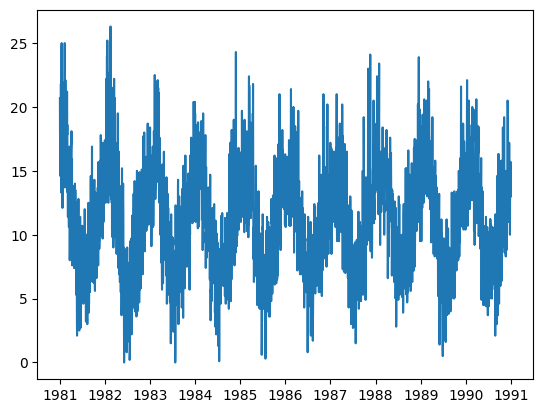

In [ ]:
daily_min = pd.read_csv("daily-min-temperatures.csv")
daily_min['Date'] = pd.to_datetime(daily_min['Date'])
plt.plot(daily_min.Date, daily_min.Temp);

In [ ]:
split_time = int(len(daily_min)*.8)

time_train = daily_min['Date'][:split_time]
x_train = daily_min['Temp'][:split_time]
time_valid = daily_min['Date'][split_time:]
x_valid = daily_min['Temp'][split_time:]
sub_arry = daily_min['Temp'].values

window_size = 30
batch_size = 64
shuffle_buffer_size = 1000

In [ ]:
# this is trailing windowed data
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

def windowed_centered_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size * 2 + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size * 2 + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:window_size], window[window_size]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
val_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

(1e-08, 0.0001, 0.0, 30.0)

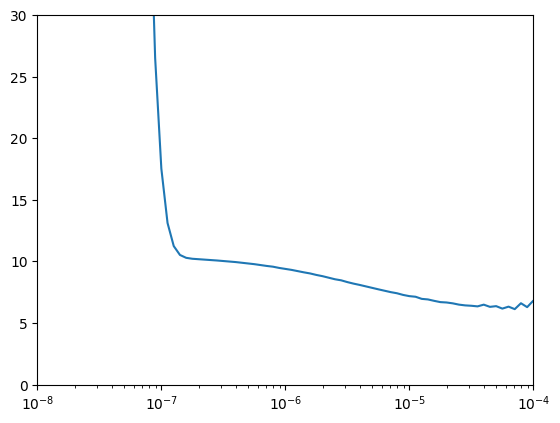

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation="relu", input_shape=[window_size]),
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1)
])

# using a learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-08 * 10**(epoch / 20))

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-08, momentum=0.9))
history = model.fit(dataset,epochs=200,verbose=0,callbacks=[lr_schedule])

# picking a learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-08, 1e-4, 0, 30])

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9))
history = model.fit(dataset,epochs=10,verbose=1)

Epoch 1/10
46/46 [==============================] - 5s 11ms/step - loss: 62.2522
Epoch 2/10
46/46 [==============================] - 0s 7ms/step - loss: 8.8351
Epoch 3/10
46/46 [==============================] - 0s 7ms/step - loss: 8.4465
Epoch 4/10
46/46 [==============================] - 0s 7ms/step - loss: 8.1808
Epoch 5/10
46/46 [==============================] - 0s 7ms/step - loss: 7.9664
Epoch 6/10
46/46 [==============================] - 0s 6ms/step - loss: 7.8204
Epoch 7/10
46/46 [==============================] - 0s 7ms/step - loss: 7.7045
Epoch 8/10
46/46 [==============================] - 0s 7ms/step - loss: 7.5881
Epoch 9/10
46/46 [==============================] - 0s 7ms/step - loss: 7.5294
Epoch 10/10
46/46 [==============================] - 0s 7ms/step - loss: 7.4206


12/12 [==============================] - 1s 25ms/step
(730,)
(730,)


<Figure size 2000x600 with 0 Axes>

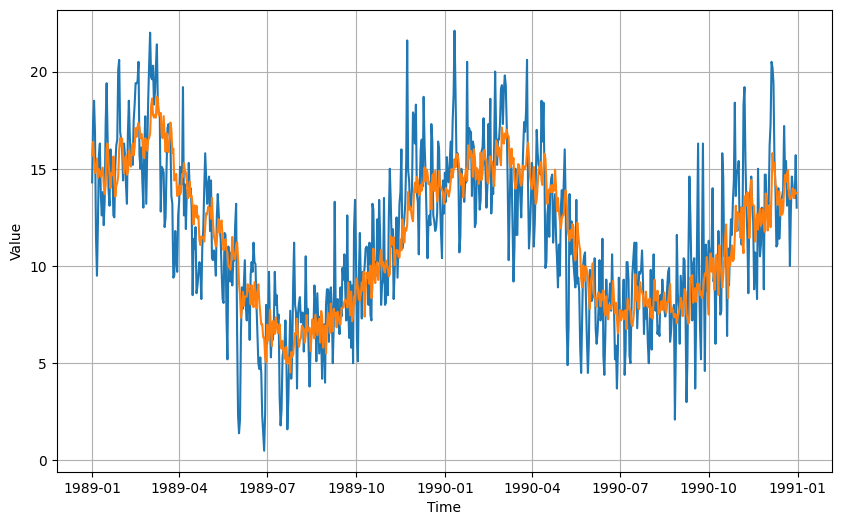

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

def plot_series(time, series, format="-", start=0, end=None):
    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


plt.figure(figsize=(20, 6))

# Reduce the original series
forecast_series = sub_arry[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)


# Drop single dimensional axis
results = forecast.squeeze()
print(results.shape)
print(x_valid.shape)

# Plot the results
plot_series(time_valid, (x_valid, results))

In [ ]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

4.9243865
1.7425337


In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
val_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
  #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(30,activation='relu'),
  tf.keras.layers.Dense(10,activation='relu'),
  tf.keras.layers.Dense(1)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(dataset, validation_data = val_dataset, epochs=100)

In [ ]:
# multi-variate time series example
pc = pd.read_csv("/content/household_power_consumption.csv",infer_datetime_format=True,index_col='datetime')

def normalize_series(data,min,max):
  data -= min
  data /= max
  return data

In [ ]:
data = pc.values
split_time = int(len(data)*0.5)
data = normalize_series(data,np.min(data,axis=0),np.max(data,axis=0))

In [ ]:
time_train = pc.index[:split_time]
time_valid = pc.index[split_time:]

In [ ]:
x_train = data[:split_time]
x_valid = data[split_time:]

BATCH_SIZE = 32
N_PAST = 24
N_FUTURE = 24
N_FEATURES = data.shape[1]
SHIFT = 1

def windowed_dataset(series, batch_size, n_past=24, n_future=24, shift=24):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(n_past + n_future, shift=shift,drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(n_past + n_future))
  dataset = dataset.shuffle(1000).map(lambda window: (window[:n_future], window[-n_future:,:1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

dataset = windowed_dataset(x_train, N_PAST, N_FUTURE, BATCH_SIZE, SHIFT)
val_dataset = windowed_dataset(x_valid, N_PAST, N_FUTURE, BATCH_SIZE, SHIFT)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, N_FEATURES]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Dense(50,activation='relu'),
  tf.keras.layers.Dense(N_FUTURE)
])

# early stopping
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if logs.get('mae') < .09 and logs.get('val_mae') < .09:
      print("\nReached 99.5% accuracy so cancelling training")
      self.model.stop_training = True

callbacks = myCallback()

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(dataset, validation_data = val_dataset, epochs=100,callbacks=[callbacks])

Epoch 1/100
1798/1798 [==============================] - 41s 20ms/step - loss: 0.0141 - mae: 0.1232 - val_loss: 0.0085 - val_mae: 0.0993
Epoch 2/100
1798/1798 [==============================] - 38s 21ms/step - loss: 0.0089 - mae: 0.1052 - val_loss: 0.0075 - val_mae: 0.0964
Epoch 3/100
1798/1798 [==============================] - 44s 24ms/step - loss: 0.0081 - mae: 0.1004 - val_loss: 0.0070 - val_mae: 0.0925
Epoch 4/100
1798/1798 [==============================] - 42s 24ms/step - loss: 0.0075 - mae: 0.0957 - val_loss: 0.0065 - val_mae: 0.0883
Epoch 5/100
1798/1798 [==============================] - 36s 20ms/step - loss: 0.0070 - mae: 0.0910 - val_loss: 0.0062 - val_mae: 0.0843
Epoch 6/100
1797/1798 [============================>.] - ETA: 0s - loss: 0.0066 - mae: 0.0865
Reached 99.5% accuracy so cancelling training
1798/1798 [==============================] - 36s 20ms/step - loss: 0.0066 - mae: 0.0865 - val_loss: 0.0059 - val_mae: 0.0807


In [ ]:
forecast = model.predict(val_dataset)

1798/1798 [==============================] - 15s 8ms/step


In [ ]:
model.evaluate(val_dataset)

1798/1798 [==============================] - 16s 9ms/step - loss: 0.0062 - mae: 0.0845


[0.006192844361066818, 0.08454924076795578]